# Classification Metrics
Author: Kim Hazed Delfino

## Imports

In [168]:
import pandas as pd
import numpy as np
# for creating confusion metrix heatmap
import matplotlib.pyplot as plt
import seaborn as sns 
# Necessary tools 
from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
# Score metrics 
from sklearn.metrics import accuracy_score, precision_score,classification_report, ConfusionMatrixDisplay, confusion_matrix
# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

#ignore warning when model fitted with feature_names unnused
import warnings
warnings.filterwarnings("ignore") 


## Breast Cancer Dataset

### Load Data

In [169]:
data  = load_breast_cancer()
X = pd.DataFrame(data.data, columns= data.feature_names)
y = pd.DataFrame(data.target, columns=["outcome"])
print(y.value_counts(normalize=True))
X.head()

outcome
1          0.627417
0          0.372583
dtype: float64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [170]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [171]:
# Split Train-test 
X_train , X_test , y_train , y_test = train_test_split(X, y, random_state=42)

### Custom class to Instantiate and Train Models

In [172]:
class ClfMetrics:
    def __init__(self, model, X_train, X_test, y_train, y_test, 
                 labels):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test 
        self.labels = labels

        #Instantiate and train model 
        model_map = {
            "dt_clf" : DecisionTreeClassifier,
            # added baggin/rf models for score comparison
            "bag_clf" : BaggingClassifier,
            "rf_clf" : RandomForestClassifier
        }
        if model == "dummy_clf":
            model_clf = DummyClassifier(strategy="most_frequent")
        else:
            model_clf = model_map[self.model](random_state=42)
        num_selector = make_column_selector(dtype_include="number")
        scaler = StandardScaler()
        model_tuple = (scaler,num_selector)
        preprocessor = make_column_transformer(model_tuple)
        model_clf_pipe = make_pipeline(preprocessor,model_clf)
        model_clf_pipe.fit(X_train,y_train)
        # set prediction
        self.model_train_pred = model_clf_pipe.predict(X_train)
        self.model_test_pred = model_clf_pipe.predict(X_test)
        # set classfication report
        self.train_dt_report = classification_report(y_train,self.model_train_pred,
                                                target_names=labels)
        self.test_dt_report = classification_report(y_test, self.model_test_pred,
                                            target_names=labels)
        
    # Display Confusion Report 
    def get_train_report(self):
        return print(f"{self.model} Train Metric Scores: \n {self.train_dt_report}")

    def get_test_report(self):    
        return print(f"{self.model} Test Metric Scores: \n {self.test_dt_report}")

    def get_visuals(self, normalize = None):
        # Display Confusion Matrix
        fig, axes = plt.subplots(ncols= 2, figsize=(10,5))
        ConfusionMatrixDisplay.from_predictions(self.y_train, 
                                                self.model_train_pred,
                                                ax=axes[0],
                                                cmap="Blues",
                                                normalize=normalize)
        axes[0].set_title("Train CM")
          
        ConfusionMatrixDisplay.from_predictions(self.y_test, 
                                                self.model_test_pred,
                                                ax=axes[1],
                                                cmap="Reds",
                                                normalize=normalize)
        axes[1].set_title("Test CM")
        
        return plt.show()
        


- Which of these do you think is worse in this case? If we have to increase one kind of error in order to minimize the other kind, which would we want to minimize? Why?
    - In this dataset , I think getting False Negative (type2) prediction is more problematic since they are actually ill but did not receive any treatment

### Visualize Reports and Heatmap

In [173]:
# Target names for breast cancer dataset 
bc_labels = ["Benign","Malignant" ]

#Instantiate DecisionTree Classifier Model
dt_clf = ClfMetrics("dt_clf", X_train , X_test , y_train , y_test, bc_labels)
#get test report
dt_clf.get_test_report()

dt_clf Test Metric Scores: 
               precision    recall  f1-score   support

      Benign       0.93      0.94      0.94        54
   Malignant       0.97      0.96      0.96        89

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



In [174]:
# Get train report
dt_clf.get_train_report()

dt_clf Train Metric Scores: 
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       158
   Malignant       1.00      1.00      1.00       268

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426



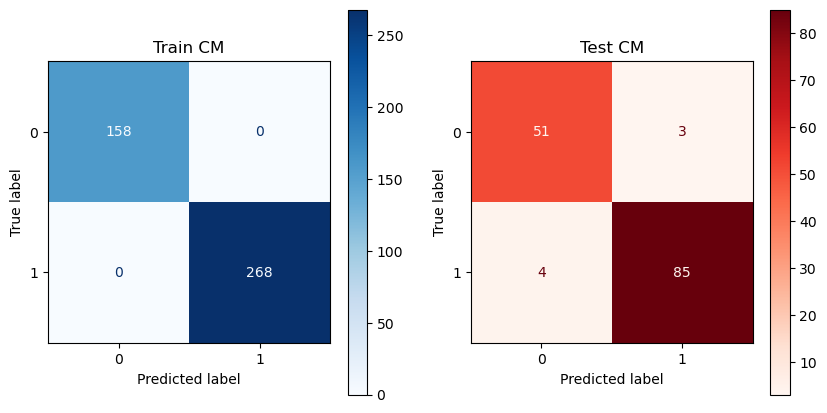

In [175]:
#get ConfusionMatrix visuals
dt_clf.get_visuals()

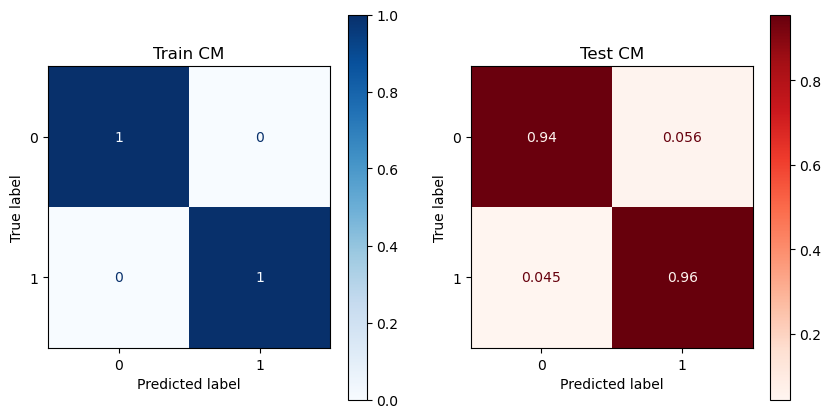

In [176]:
# show CM with normalize = true
dt_clf.get_visuals(normalize='true')

In [177]:
# Instantiate Dummy Classifier strategy = most_frequent
dummy_clf = ClfMetrics("dummy_clf", X_train , X_test , y_train , y_test, bc_labels)

In [178]:
# Get train report
dummy_clf.get_train_report()

dummy_clf Train Metric Scores: 
               precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       158
   Malignant       0.63      1.00      0.77       268

    accuracy                           0.63       426
   macro avg       0.31      0.50      0.39       426
weighted avg       0.40      0.63      0.49       426



In [179]:
# Get test report
dummy_clf.get_test_report()

dummy_clf Test Metric Scores: 
               precision    recall  f1-score   support

      Benign       0.00      0.00      0.00        54
   Malignant       0.62      1.00      0.77        89

    accuracy                           0.62       143
   macro avg       0.31      0.50      0.38       143
weighted avg       0.39      0.62      0.48       143



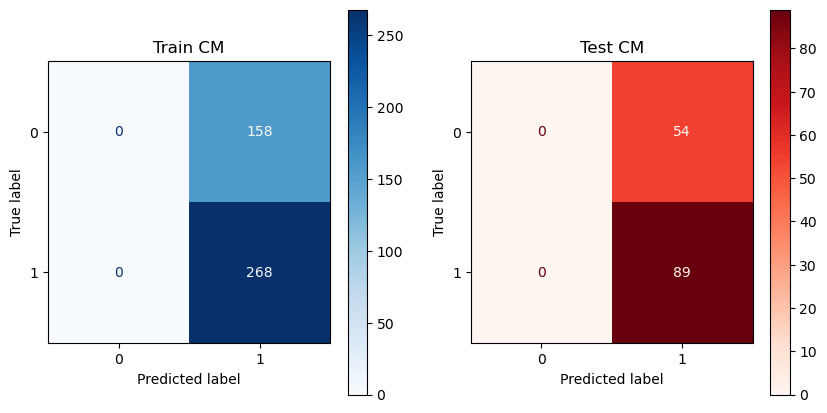

In [180]:
# show CM visuals
dummy_clf.get_visuals()

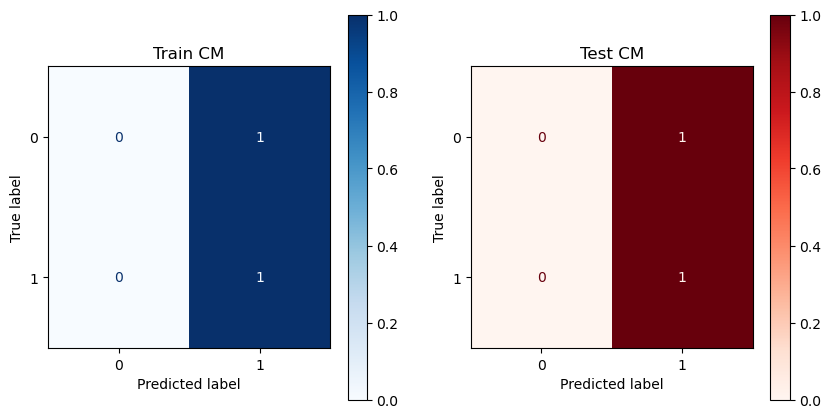

In [181]:
# Show CM visuals with normalize = true
dummy_clf.get_visuals(normalize='true')

In [182]:
# Display classification_reports on both models
dt_clf.get_train_report()
dt_clf.get_test_report()

dt_clf Train Metric Scores: 
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       158
   Malignant       1.00      1.00      1.00       268

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426

dt_clf Test Metric Scores: 
               precision    recall  f1-score   support

      Benign       0.93      0.94      0.94        54
   Malignant       0.97      0.96      0.96        89

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



In [183]:
dummy_clf.get_train_report()
dummy_clf.get_test_report()

dummy_clf Train Metric Scores: 
               precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       158
   Malignant       0.63      1.00      0.77       268

    accuracy                           0.63       426
   macro avg       0.31      0.50      0.39       426
weighted avg       0.40      0.63      0.49       426

dummy_clf Test Metric Scores: 
               precision    recall  f1-score   support

      Benign       0.00      0.00      0.00        54
   Malignant       0.62      1.00      0.77        89

    accuracy                           0.62       143
   macro avg       0.31      0.50      0.38       143
weighted avg       0.39      0.62      0.48       143



## Iris Dataset

### Load Data

In [184]:
iris = load_iris()

X_iris = pd.DataFrame(iris.data, columns = iris.feature_names)
y_iris = pd.DataFrame(iris.target)
print(y_iris.value_counts(normalize=True))
X_iris.head()

0    0.333333
1    0.333333
2    0.333333
dtype: float64


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Train Test Split

In [185]:
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(X_iris,y_iris, random_state=42)

### Visualize CM and Reports

#### Dummy Clf Model

In [186]:
# Initialize dummy model
iris_labels = ["0","1","2"]
iris_dummy_clf = ClfMetrics("dummy_clf", iris_X_train, 
                  iris_X_test, iris_y_train, 
                  iris_y_test, iris_labels)

In [187]:
# Get training report
iris_dummy_clf.get_train_report()

dummy_clf Train Metric Scores: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.35      1.00      0.52        39
           2       0.00      0.00      0.00        38

    accuracy                           0.35       112
   macro avg       0.12      0.33      0.17       112
weighted avg       0.12      0.35      0.18       112



In [188]:
# Get test report
iris_dummy_clf.get_test_report()

dummy_clf Test Metric Scores: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.29      1.00      0.45        11
           2       0.00      0.00      0.00        12

    accuracy                           0.29        38
   macro avg       0.10      0.33      0.15        38
weighted avg       0.08      0.29      0.13        38



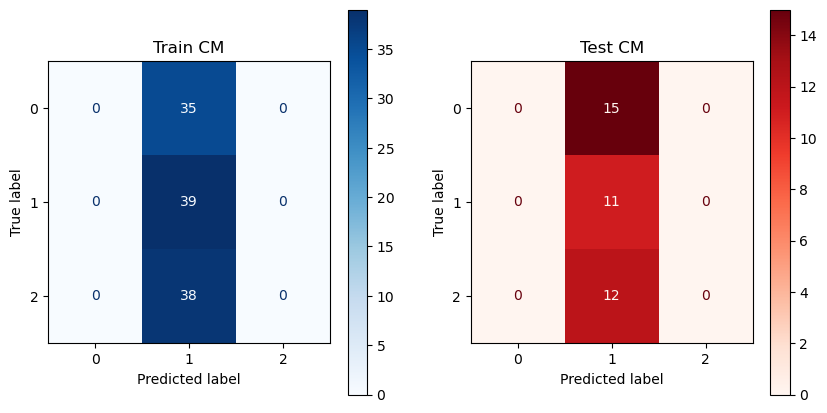

In [189]:
# Show CM Visuals
iris_dummy_clf.get_visuals()

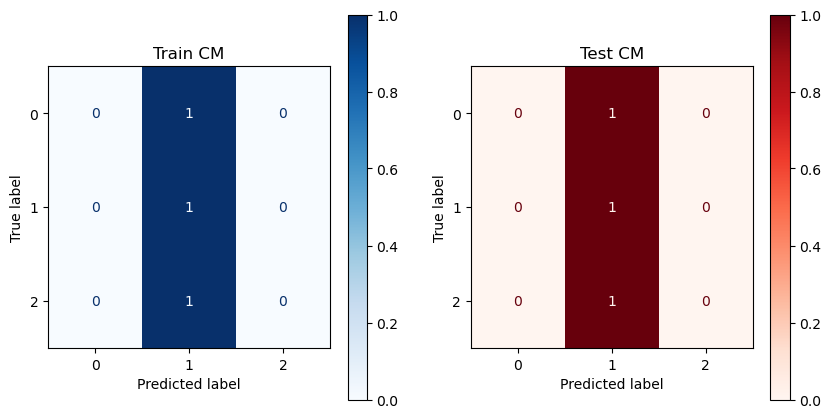

In [195]:
#Show CM Visuals with normalize = true
iris_dummy_clf.get_visuals(normalize='true')

- Here we can see that dummy clf model predicted `class-1` on `ALL predictions` which is really bad model performance

#### DecisionTree Clf Model

In [190]:
#Initialize DecisionTree Classification Model
iris_dt_clf = ClfMetrics("dt_clf", iris_X_train, 
                         iris_X_test, 
                         iris_y_train,
                         iris_y_test,
                         iris_labels)

In [191]:
# Get train report
iris_dt_clf.get_train_report()

dt_clf Train Metric Scores: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        39
           2       1.00      1.00      1.00        38

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112



In [192]:
# Get test report
iris_dt_clf.get_test_report()

dt_clf Test Metric Scores: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



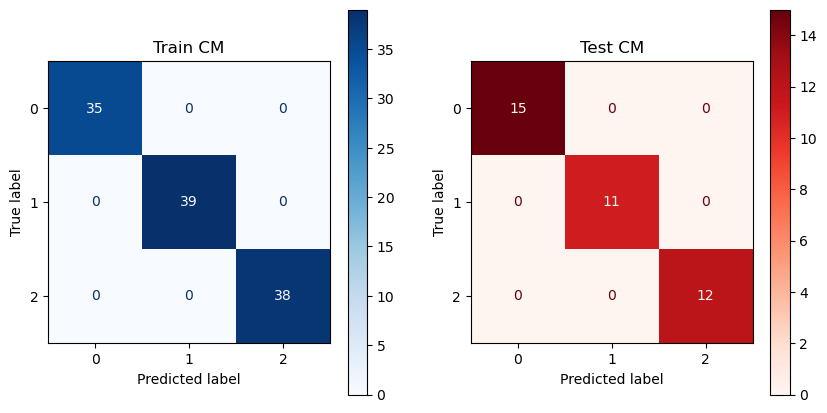

In [194]:
# Show CM Visuals
iris_dt_clf.get_visuals()

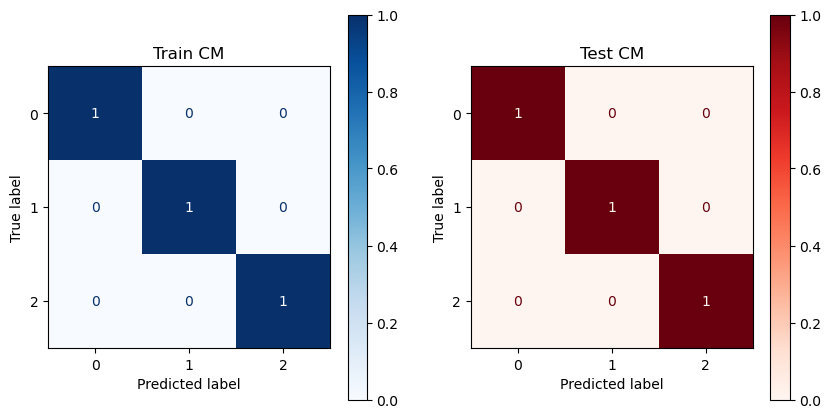

In [196]:
#Show CM Visuals with normalize = true
iris_dt_clf.get_visuals(normalize='true')

- Here we can see the `DecisionTree Classifier` did an amazing performance predicting `ALL classes correctly`